# Problem Statement:-To remove unwanted Noise in GPS Altitude Data using Statistical Filtering Method

In [1]:
import pandas as pd
import gpxpy
import matplotlib.pyplot as plt

## Reading a GPX file

GPX File format is the File format used for storeing GPS time series data It include parameter such a latitude, Longitude , Altitude etc. GPX full form is GPS Exchangable Format. So for the given problem publicly available GPX file was choosen. 

In [2]:
with open('C:\\Users\\ASUS\\Videos\\Maruti Suzuki\\gpx\\3-laender-giro.gpx') as f:
    dat = gpxpy.parse(f)
dat


GPX(tracks=[GPXTrack(segments=[GPXTrackSegment(points=[...])])])

## GPX segments can be easily converted to a Pandas dataframe

In [3]:
p=dat.tracks[0].segments[0]

In [4]:
lat=[]
lon=[]
ele=[]
tim=[]
for item in p.points:
    lat.append(item.latitude)
    lon.append(item.longitude)
    ele.append(item.elevation)
    tim.append(item.time)
data = pd.DataFrame({'time':tim,'latitude':lat,'longitude':lon,'Altitude':ele})
data.head()

,time,latitude,longitude,Altitude
0,2016-06-26 04:31:27+00:00,46.889062,10.502119,1343.0
1,2016-06-26 04:31:28+00:00,46.889062,10.502119,1343.0
2,2016-06-26 04:31:29+00:00,46.889062,10.502119,1343.0
3,2016-06-26 04:31:30+00:00,46.889065,10.502119,1344.0
4,2016-06-26 04:31:31+00:00,46.889068,10.502121,1345.0


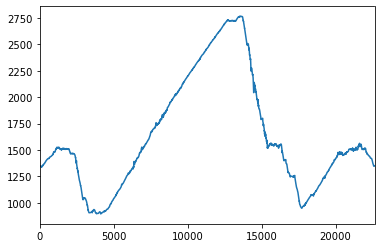

In [5]:
data['Altitude'].plot()

We can observed that there is slight noise in altitude signal and might need some noise reduction technique.lets zoom in a little to observe noise.

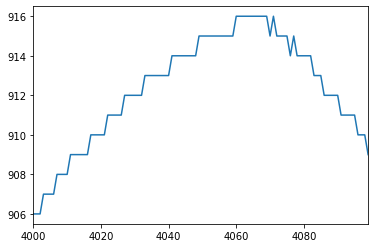

In [6]:
data['Altitude'][4000:4100].plot()

From figure we can observe that there is step like increment of about 1 meter at each altitude sample. From observing this signal we feel that jump shall be gradual instead of step like jump and is due to limitation of resolution of altitude parameter. This limitation can be overcomed by some filtering techniques which are listed below

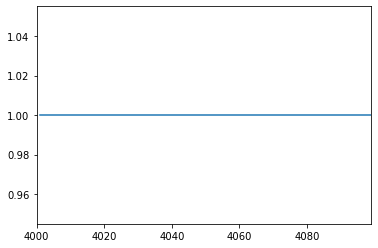

In [7]:
data['time'][4000:4100].diff().dt.seconds.plot()


To be sure that this non continous behavior is not due to data loss or time jump, in above figure we are plotting elapsed time between two rows and can observe that data is comeing at 1 second continous interval and there is no data loss.

## Moving average filter

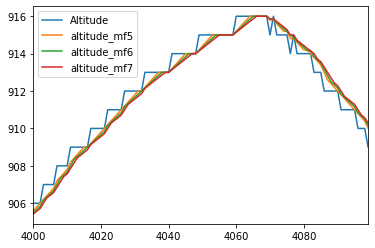

In [8]:
data['altitude_mf5']=data['Altitude'].rolling(window=5).mean()
data['altitude_mf6']=data['Altitude'].rolling(window=6).mean()
data['altitude_mf7']=data['Altitude'].rolling(window=7).mean()
data[['Altitude','altitude_mf5','altitude_mf6','altitude_mf7']][4000:4100].plot()

We can see that with diffrent combinations of moving average window we are accounting for some loss especialliy when altitude is decreasing from 4060 seconds. overall moving average is not able to capture transient behavior of Altitude properly

## savitzky Golay Filter

Text(0.5, 1.0, '11 sample window size Savitzky Golay filter')

<Figure size 432x288 with 0 Axes>

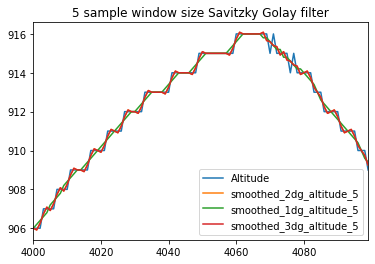

<Figure size 432x288 with 0 Axes>

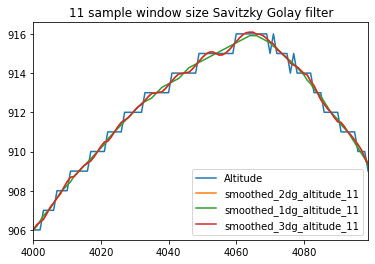

In [9]:
from scipy.signal import savgol_filter
smoothed_2dg_11 = savgol_filter(data['Altitude'].values, window_length=11, polyorder=2)
smoothed_2dg_5 = savgol_filter(data['Altitude'].values, window_length=5, polyorder=2)

smoothed_1dg_11 = savgol_filter(data['Altitude'].values, window_length=11, polyorder=1)
smoothed_1dg_5 = savgol_filter(data['Altitude'].values, window_length=5, polyorder=1)

smoothed_3dg_11 = savgol_filter(data['Altitude'].values, window_length=11, polyorder=3)
smoothed_3dg_5 = savgol_filter(data['Altitude'].values, window_length=5, polyorder=3)

data['smoothed_2dg_altitude_5'] = smoothed_2dg_5
data['smoothed_1dg_altitude_5'] = smoothed_1dg_5
data['smoothed_3dg_altitude_5'] = smoothed_3dg_5
fig1=plt.figure()
data[['Altitude','smoothed_2dg_altitude_5','smoothed_1dg_altitude_5','smoothed_3dg_altitude_5']][4000:4100].plot()
plt.title('5 sample window size Savitzky Golay filter')

data['smoothed_2dg_altitude_11'] = smoothed_2dg_11
data['smoothed_1dg_altitude_11'] = smoothed_1dg_11
data['smoothed_3dg_altitude_11'] = smoothed_3dg_11
fig2 = plt.figure()
data[['Altitude','smoothed_2dg_altitude_11','smoothed_1dg_altitude_11','smoothed_3dg_altitude_11']][4000:4100].plot()
plt.title('11 sample window size Savitzky Golay filter')

Chosing filter window size is hit and trial method & depends on raw data signal trend and is conditional. Here, Domain experience come handy in putting logical guess to initial filter coefficients. From the experience it was felt that rate of change of  Altitude will be constant for every 50m distance travelled. imagine vehicle moving at 36kmph or 10m/s, time taken to cover 50m will be 5sec. Since observation is coming at every 1sec window, 5sec will correspond to 5 samples and hence it was thought to 5 samples window size. Regarding the polynomila eqution order that needs to be fit on this window size since rate change is assuemed constant, so linear order polynomial appears to be best fit for the window size.

We observed that 5sec window was doing its job but was not satisfactory. Hence it was decided to increase the window size from 5 to 11. i.e treat altitude rate as constant for every 100m distance travelled. this combination (11 window size & polynomial order 1 ) was giving the most desired results.

# Moving Average VS savitzky Golay Filter

Moving average filter is the filtering Techniques used for removeing sudden change or sudden noise in slow moving data like Temprature , Height. So it is good method for Removing noise in slow moving signal because by replaceing the noise value with average of near by neighbourhood value.

savitzky Golay Filter is the filtering Techniques used for removeing noise in fast moving signal such as speed, electrical parameter ete. since signal values in fast moving signal are different, average value is not the correct method for representing those signal values and hence regression line or polynomial line is best method to represent those signal values.

For the given problem signal is changing fastly hence savitzky Golay Filter Giving better result as compare to moving avreage


## Kalman Filter

In [10]:
from pykalman import KalmanFilter
import numpy as np

## Kalman Filter and Smoother

* *State equation*: $\mathbf{x}_{k}=\mathbf{F}_{k}\mathbf {x}_{k-1}+\mathbf{B}_{k}\mathbf{u}_{k}+\mathbf{\epsilon}_{k}$ where 
  
  - $\mathbf{x}_{k}$ is the state vector at timestep $k$,
  - $\mathbf{u}_{k}$ is the control vector at timestep $k$,
  - $\mathbf{F}_{k}$ is the state transition matrix,
  - $\mathbf{B}_{k}$ is the control-input matrix,
  - $\mathbf{\epsilon}_{k}$ is the process noise $\mathbf{\epsilon}_{k}\sim{\mathcal{N}}(0,\mathbf{Q})$ with covariance $\mathbf{Q}$ 
  

* *Measurement equation*: $\mathbf{z}_{k}=\mathbf{H}_{k}\mathbf{x}_{k}+\mathbf{\delta}_{k}$ where

  - $\mathbf{z}_{k}$ is the measurement vector at timestep $k$,
  - $\mathbf{H}_{k}$ is the observation matrix,
  - $\mathbf{\delta}_{k}$ is the observation noise $\mathbf{\delta}_{k}\sim{\mathcal{N}}(0,\mathbf{R})$ with covariance $\mathbf{R}$ 

## Optimally average measurement and state estimation

Let
* $\mathbf{\hat{x}}_{k}^{-}$ be the *a priori*  state estimate with knowledge about the process prior to $k$
* $\mathbf{\hat{x}}_{k}$ be the *a posteriori* state estimate including the the measurement $z_{k}$

and an update equation linking $\mathbf{\hat{x}}_{k}$ to $\mathbf{\hat{x}}_{k}^{-}$, i.e.

$$\mathbf{\hat{x}}_{k} = \mathbf{\hat{x}}_{k}^{-} + \mathbf{K_k}(\mathbf{\mathbf{z}_{k} - \mathbf{H}\hat{x}}_{k}^{-})$$

where $\mathbf{K_k}$ is the *Kalman gain* at timestep $k$.

**Goal:** Find an optimal $\mathbf{K}_k$ that minimizes the *a posteriori* estimate error covariance $\mathbf{P}_{k} = \mathbb{E}[\mathbf{e}_k,\mathbf{e}_k]$ with $\mathbf{e}_{k}\equiv\mathbf{x}_{k}-\mathbf{\hat{x}}_{k}$.


Given position $\mathbf{x}_{k}=(x_{k},y_{k},z_{k})$ and velocity $\mathbf{v}_{k}=(\alpha_{k},\beta_{k},\gamma_{k})$ our model state equation is
<big>$$\mathbf{x}_{k+1} = \mathbf{x}_{k} + \mathbf{v}_{k}dt + \mathbf{\epsilon}_{k},\quad \mathbf{v}_{k+1}=\mathbf{v}_{k}+ \mathbf{\epsilon}_{k}$$</big>
or in vector notation
$$
\begin{pmatrix}
x_{k+1} \\
y_{k+1} \\
z_{k+1} \\
\alpha_{k+1} \\
\beta_{k+1} \\
\gamma_{k+1} \\
\end{pmatrix}=
\begin{pmatrix}
1 & 0 & 0 & dt & 0 & 0 \\
0 & 1 & 0 & 0 & dt & 0 \\
0 & 0 & 1 & 0 & 0 & dt \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
\cdot
\begin{pmatrix}
x_{k} \\
y_{k} \\
z_{k} \\
\alpha_{k} \\
\beta_{k} \\
\gamma_{k} \\
\end{pmatrix}+
\begin{pmatrix}
\epsilon^1_{k} \\
\epsilon^2_{k} \\
\epsilon^3_{k} \\
\epsilon^4_{k} \\
\epsilon^5_{k} \\
\epsilon^6_{k} \\
\end{pmatrix}.
$$
For the sampling rate in our date $dt=1$.

Therefore State Trascition Matrix (F) is = \begin{pmatrix}
1 & 0 & 0 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 & 1 & 0 \\
0 & 0 & 1 & 0 & 0 & 1 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}

Given measurement $\mathbf{z}_{k}=(\tilde{x}_k,\tilde{y}_k,\tilde{z}_k)$ our measurement equation is
<big> $$\mathbf{z}_{k}=\mathbf{H}_{k}\mathbf{x}_{k}+\mathbf{\delta}_{k}$$</big>
or in vector notation
$$
\begin{pmatrix}
\tilde{x}_k\\
\tilde{y}_k\\
\tilde{z}_k\\
\end{pmatrix}=
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
\end{pmatrix}\cdot
\begin{pmatrix}
x_{k} \\
y_{k} \\
z_{k} \\
\alpha_{k} \\
\beta_{k} \\
\gamma_{k} \\
\end{pmatrix}+
\begin{pmatrix}
\delta^1_{k} \\
\delta^2_{k} \\
\delta^3_{k} \\
\end{pmatrix}.
$$
The observation covariance matrix $\mathbf{R}=diag(1e-4,1e-4,10)$ where $1e-4$ is roughly 10-30m in longitude/latitude.

Therefore Observation matrix (H) is =
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
\end{pmatrix}\

## making Time Interval Constant as 1 second for kalman filter to work

In [11]:
data['time']=np.round(data['time'].astype(int),-9).astype('datetime64[ns]')

We are doing this to ensure that timestamp that we are using for prediction using kalman filter shall come at every uniform time interval otherwise our Kalman filter will not work properly.

## Dealing with missing Data

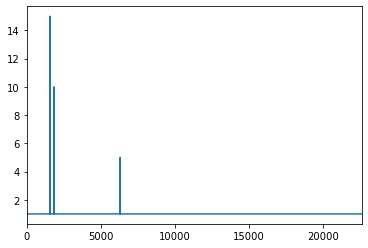

In [12]:
 data['time'].diff().dt.seconds.plot()

As we can see from tht data there are three places where there is time jump. These time instants are as follows.

In [13]:
data['time'][data['time'].diff().dt.seconds>1]

1550   2016-06-26 04:57:31
1819   2016-06-26 05:02:09
6301   2016-06-26 06:16:55
Name: time, dtype: datetime64[ns]

Since we want each row or observation shall come at uniform time interval of 1 second we have to interpolate or fill extra rows between these time jump events.Using Resample function we can insert additional rows between the events where time jump was observed. These rows will be all NaN values. In this example we have inserted additional rows between time jump events at 1 second


In [14]:
data.set_index(['time'],inplace=True)  
data.resample('1S').asfreq()

,latitude,longitude,Altitude,altitude_mf5,altitude_mf6,altitude_mf7,smoothed_2dg_altitude_5,smoothed_1dg_altitude_5,smoothed_3dg_altitude_5,smoothed_2dg_altitude_11,smoothed_1dg_altitude_11,smoothed_3dg_altitude_11
time,,,,,,,,,,,,
2016-06-26 04:31:27,46.889062,10.502119,1343.0,NaN,NaN,NaN,1343.028571,1342.6,1343.028571,1342.335664,1342.772727,1342.860140
2016-06-26 04:31:28,46.889062,10.502119,1343.0,NaN,NaN,NaN,1342.885714,1343.1,1342.885714,1343.097902,1343.272727,1342.993007
2016-06-26 04:31:29,46.889062,10.502119,1343.0,NaN,NaN,NaN,1343.171429,1343.6,1343.171429,1343.801865,1343.772727,1343.417249
2016-06-26 04:31:30,46.889065,10.502119,1344.0,NaN,NaN,NaN,1343.914286,1344.2,1343.914286,1344.447552,1344.272727,1344.045455
2016-06-26 04:31:31,46.889068,10.502121,1345.0,1343.6,NaN,NaN,1345.085714,1344.8,1345.085714,1345.034965,1344.772727,1344.790210
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-26 10:49:01,46.888570,10.502008,1350.0,1349.2,1349.166667,1349.142857,1349.742857,1349.6,1349.742857,1349.538462,1349.590909,1349.652681
2016-06-26 10:49:02,46.888573,10.502010,1350.0,1349.4,1349.333333,1349.285714,1350.085714,1349.8,1350.085714,1349.692308,1349.727273,1349.879953
2016-06-26 10:49:03,46.888574,10.502012,1350.0,1349.6,1349.500000,1349.428571,1350.000000,1350.0,1350.000000,1349.857809,1349.863636,1350.037296


We need to mask these extra NaN values of Altitude, Latitude and Longitude values which came after resampling so that any computaion shall not take place on these extra invalid measurements of these parameters. Steps are as below



In [15]:
measurements=np.ma.masked_invalid(data[['latitude','longitude','Altitude']].values)

## Initialising the Kalman Filter

For the sake of explaining terminologies of the Kalman filter, let’s take a simple model which has a state equation of  
x(t)=F*x(t-1)+w(t)  
and an observation equation of  
y(t)=H*x(t)+e(t)  
where we assume  
w(t) ~N(0,E)  
and  
e(t)~N(0,R)  
.  
The basic one-dimensional Kalman filtering algorithm is as follows. We start with an initial state x00  
and initial variance P00  
. From here we compute next states as  
x10=F*x00 + w0 where w0 belong to Gaussian Distribution N (0, E)

P10=F^2*P00+E
F is called as State Transition Matrix  
x(t) is state at time t  
x(t-1) is state at time t-1  
y(t) is measured value at time t  
H is Measurement matrix  
w(t) is Process error which we want to minimise and is assumed as Gaussian distribution with mean 0 and having Process Variance as E  
e(t) is Measurement error which can be assumed as Gaussian distribution with mean 0 and Measurement Variance of R  

In [16]:

F = np.array([[1, 0, 0, 1, 0, 0], # Transition Matrix  
[0, 1, 0, 0, 1, 0],  
[0, 0, 1, 0, 0, 1],  
[0, 0, 0, 1, 0, 0],  
[0, 0, 0, 0, 1, 0],  
[0, 0, 0, 0, 0, 1]])  
H = np.array([[1, 0, 0, 0, 0, 0], # Measurement matrix  
[0, 1, 0, 0, 0, 0],  
[0, 0, 1, 0, 0, 0]])  
R = np.diag([1e-4, 1e-4, 10])**2 # Mesaurement Co-Variance  

In [17]:
initial_state_mean = np.hstack([measurements[0, :], 3*[0.]])
# This is x00 (initial state).First 3 are initial states for position and last3 are initial states for speed  
initial_state_covariance = np.diag([1e-4, 1e-4, 5, 1e-6, 1e-6, 1e-6])**2 
# this is P00 (initial variance). first 3 are tolerance ranges of Position and last 3 are tolerances of Speed

## Building Kalman Filter  

In [18]:
from pykalman import KalmanFilter as kf  
filt= kf(transition_matrices=F,observation_matrices=H,observation_covariance=R,initial_state_mean=initial_state_mean,initial_state_covariance=initial_state_covariance,em_vars=['transition_covariance'])

## Fitting the Kalman Filter on Measurement data to get estimate of Process CoVariance (E) 

In [ ]:
filtered_measurements=filt.em(measurements,n_iter=1000) # takes a very long time

In [ ]:
new_measurement_values , new_measurement_vari = filtered_measurements.smooth(measurements)

In [ ]:
new_measurement_values[:,2]

In [ ]:
data['kalman_filtered_Altitude'] = new_measurement_values[:,2]
data[['Altitude','kalman_filtered_Altitude']].plot()

In [ ]:
data[['Altitude','kalman_filtered_Altitude']].iloc[:4000].plot()

Out of the three filter applied savitzky Golay Filter and kalman Filter are giving Good results But i will prefer to go with kalman filter Because in kalman filter we are making prediction based on system understanding which are more logical estiatimation compare to savitzky Golay Filter method which is making decsion based on trend of the signal and fiting polynomial curve on data paoints. Hence In savitzky Golay Filter there is a chance of overfitting and this filter will not work on unseen or complex noise senario.